[INFO] Found labels: [ 1  3 12 24 34 40]
[INFO] Filling 19 unassigned components...
[INFO] Refinement complete.


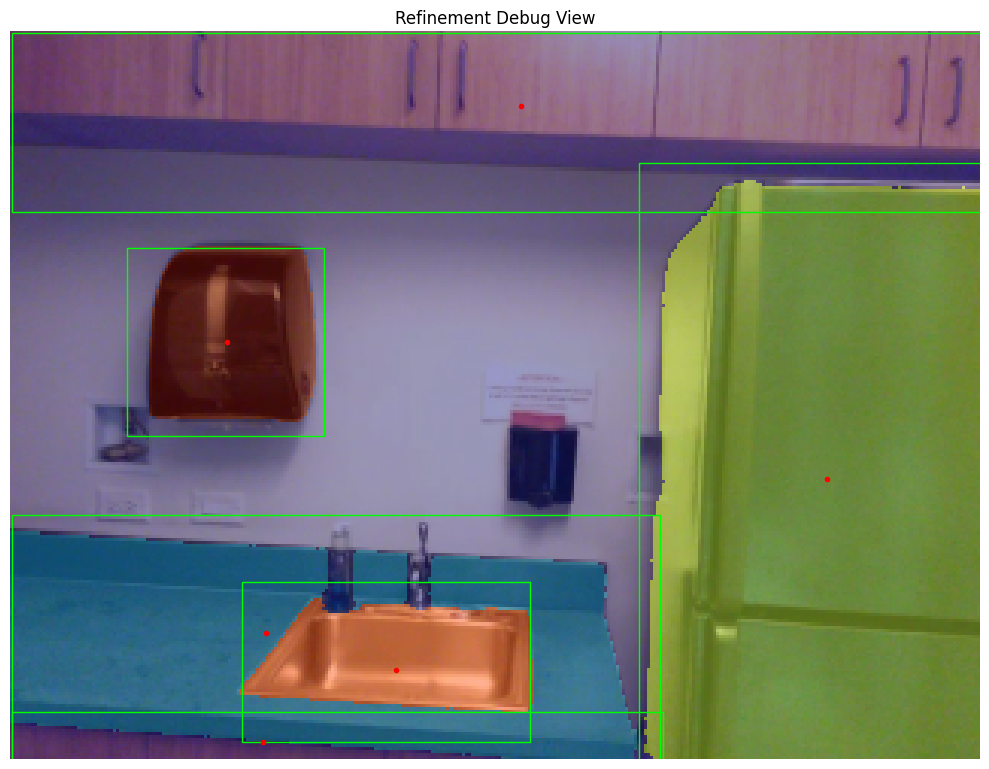

In [7]:
# === Imports ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import SAM
from FastSamRefiner import SAM2RefinerMixed

def rgb_to_class_index(rgb_image, class_colors, tolerance=5):
    h, w = rgb_image.shape[:2]
    class_map = np.zeros((h, w), dtype=np.int32)
    for class_idx, color in enumerate(class_colors):
        mask = np.all(np.abs(rgb_image - color) <= tolerance, axis=-1)
        class_map[mask] = class_idx
    return class_map

def labels_to_rgb(label_img,class_colors):
    """Convert label indices (H, W) to RGB image using predefined colormap."""
    sem_new = np.zeros((label_img.shape[0], label_img.shape[1], 3), dtype=np.uint8)
    for i in range(41):  # self.max_classes is 41
        sem_new[label_img == i] = class_colors[i]
    return sem_new
# === Static Paths ===
mapping = np.genfromtxt("nyu40_segmentation_mapping.csv", delimiter=",")[1:, 1:4]
class_colors = mapping
image_path = "./test_db/color/618.jpg"         # Path to RGB image
pseudo_mask_path = "./test_db/pseudo/618.png"   # Path to pseudo label (color)

pseudo_bgr = cv2.imread(pseudo_mask_path)
pseudo_rgb = cv2.cvtColor(pseudo_bgr, cv2.COLOR_BGR2RGB)
model_path = "sam2_b.pt"         # Path to SAM2 model weights

# === Load Inputs ===
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb= cv2.resize(image_rgb,(320,240),interpolation=cv2.INTER_AREA)
pseudo_mask = rgb_to_class_index(pseudo_rgb, class_colors)

# === Refine ===
refiner = SAM2RefinerMixed(skip_labels=[1])
refined_mask = refiner.refine(image_rgb, pseudo_mask)




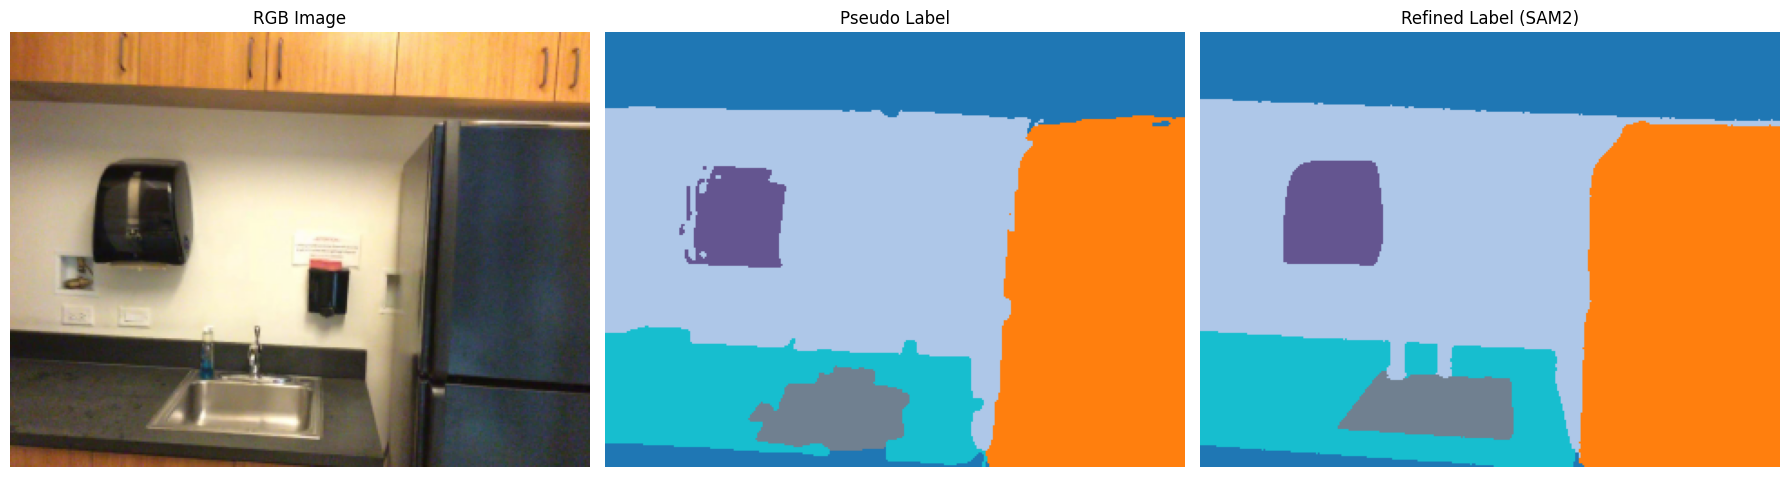

In [8]:
# === Display ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(image_rgb)
axs[0].set_title("RGB Image")
axs[0].axis("off")

axs[1].imshow(pseudo_rgb)
axs[1].set_title("Pseudo Label")
axs[1].axis("off")

axs[2].imshow(labels_to_rgb(refined_mask,class_colors))
axs[2].set_title("Refined Label (SAM2)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [9]:
import numpy as np

def compute_iou(pred_mask: np.ndarray, gt_mask: np.ndarray, num_classes: int) -> float:
    """
    Compute Mean IoU between predicted mask and ground truth, excluding pixels with GT=0.

    Args:
        pred_mask (np.ndarray): Predicted mask (H, W).
        gt_mask (np.ndarray): Ground truth mask (H, W).
        num_classes (int): Number of semantic classes.

    Returns:
        float: Mean IoU across classes.
    """
    valid_mask = gt_mask > 0  # Ignore background (GT=0)
    ious = []

    for cls in range(1, num_classes):  # Start from class 1
        pred_cls = (pred_mask == cls) & valid_mask
        gt_cls = (gt_mask == cls) & valid_mask

        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()

        if union == 0:
            continue  # Class not present in GT or prediction (after masking)

        iou = intersection / union
        ious.append(iou)

    return np.mean(ious) if ious else 0.0

# === Assuming you have these ===
# pseudo_mask: predicted from RGB pseudo color map
# refined_mask: result from SAM2Refiner
# gt_mask: ground truth label map (with class indices)

num_classes = 41  # NYUv2 or similar
gt_mask = cv2.imread("./test_db/GT/618.png")
gt_rgb = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
gt_mask= cv2.resize(gt_rgb,(320,240),interpolation=cv2.INTER_AREA)
gt_mask = rgb_to_class_index(gt_mask, class_colors)
miou_pseudo = compute_iou(pseudo_mask, gt_mask, num_classes)
miou_refined = compute_iou(refined_mask, gt_mask, num_classes)

print(f"Pseudo Label mIoU:  {miou_pseudo:.4f}")
print(f"Refined Label mIoU: {miou_refined:.4f}")

improvement = miou_refined - miou_pseudo
print(f"mIoU Improvement:   {improvement:+.4f}")


Pseudo Label mIoU:  0.8009
Refined Label mIoU: 0.8402
mIoU Improvement:   +0.0393


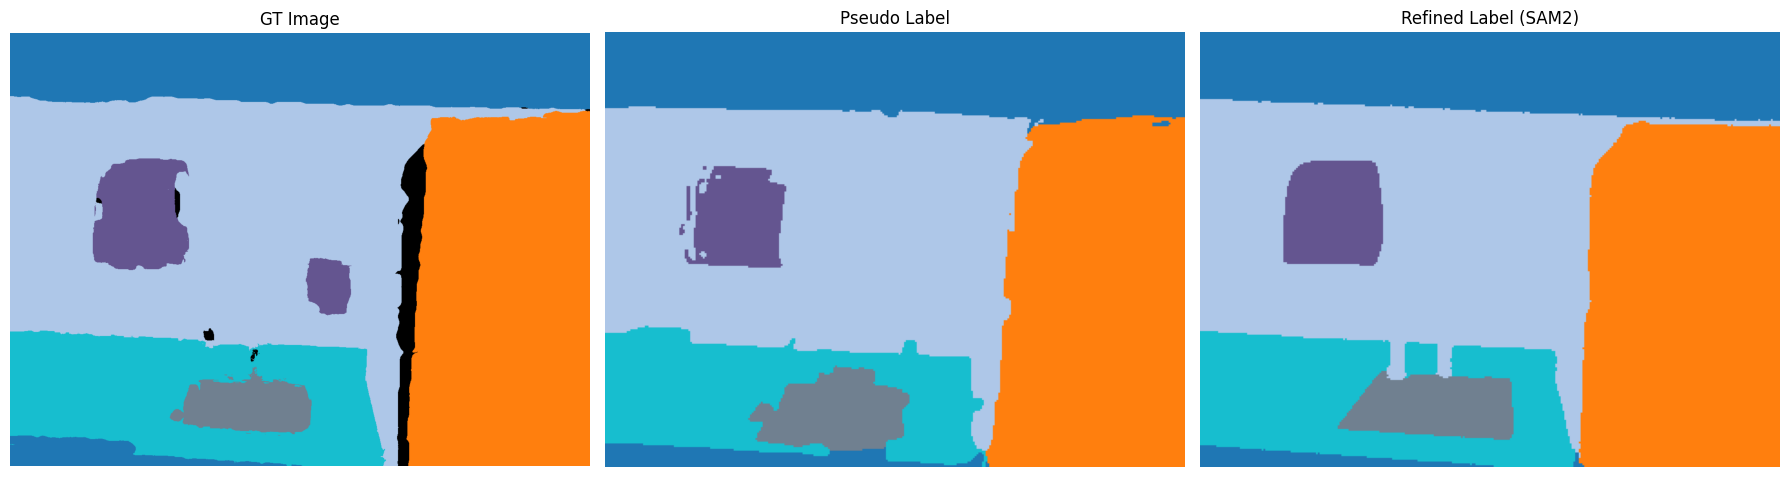

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(gt_rgb)
axs[0].set_title("GT Image")
axs[0].axis("off")

axs[1].imshow(pseudo_rgb)
axs[1].set_title("Pseudo Label")
axs[1].axis("off")

axs[2].imshow(labels_to_rgb(refined_mask,class_colors))
axs[2].set_title("Refined Label (SAM2)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from ultralytics import SAM
from PIL import Image
import matplotlib.pyplot as plt
import cv2
# Load the model (choose sam_b, sam_l, or sam_h)
model = SAM('sam2_b.pt')  # You can also use 'sam_l' or 'sam_h'

# Load your image
image_path = "./test_db/color/618.jpg" 

# === Load Inputs ===
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# Run automatic segmentation (no prompts needed)
results = model(image_rgb)

# Display the masks



KeyboardInterrupt: 

In [ ]:
for i in results:
    i.show()


